## Imports

In [1]:
import sys
import numba
import numpy as np
from collections import Counter
from math import e
from os.path import abspath, join as opj
from scipy.spatial.distance import cdist
from tqdm.notebook import tqdm
from umap import UMAP
from wordcloud import WordCloud, get_single_color_func

sys.path.insert(0, abspath('../helpers/'))
from participant import Participant
from experiment import Experiment

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
%matplotlib inline

## Set paths & params

In [2]:
datadir = '../../data'
fig_dir = '../../paper/figs/knowledge-maps-components'
embeddings_dir = opj(datadir, 'embeddings')
models_dir = opj(datadir, 'models')
maskpath = opj(datadir, 'wordle-mask.jpg')

plt.rcParams['pdf.fonttype'] = 42
sns.set_context('paper')
cmap = 'bone'

## Define some classes & functions

#### Custom distance metric for UMAP embedding

In [3]:
@numba.njit
def correlation_exp(x, y):
    x = e ** x
    y = e ** y
    mu_x = 0.0
    mu_y = 0.0
    norm_x = 0.0
    norm_y = 0.0
    dot_product = 0.0

    for i in range(x.shape[0]):
        mu_x += x[i]
        mu_y += y[i]

    mu_x /= x.shape[0]
    mu_y /= x.shape[0]

    for i in range(x.shape[0]):
        shifted_x = x[i] - mu_x
        shifted_y = y[i] - mu_y
        norm_x += shifted_x ** 2
        norm_y += shifted_y ** 2
        dot_product += shifted_x * shifted_y

    if norm_x == 0.0 and norm_y == 0.0:
        dist = 0.0
        grad = np.zeros(x.shape)
    elif dot_product == 0.0:
        dist = 1.0
        grad = np.zeros(x.shape)
    else:
        dist = 1.0 - (dot_product / np.sqrt(norm_x * norm_y))
        grad = ((x - mu_x) / norm_x - (y - mu_y) / dot_product) * dist

    return dist, grad

#### Creating and plotting knowledge/learning maps

In [4]:
def RBF_interp(obs_coords, obs_vals, pred_coords, width=10):
    def _weighted_average(weights, vals):
        return np.divide(np.sum(weights * vals), np.sum(weights))
    
    weights = np.exp(-np.divide(np.power(cdist(obs_coords, pred_coords), 2), width))
    pred_vals = np.zeros([pred_coords.shape[0]])
    for i in range(pred_coords.shape[0]):
        pred_vals[i] = _weighted_average(weights[:, i], obs_vals)
        
    return pred_vals

In [5]:
def directional_plot(
    x, 
    y, 
    line_fmt=None, 
    axes=None, 
    arrow_spacing=0.1, 
    head_scale=0.3, 
    plot_kwargs=None, 
    arrow_kwargs=None
):
    """
    Create a matplotlib with arrows connecting ordered x,y coordinates.
    Arrows can be overlaid on another linestyle, or plotted alone
    
    Parameters:
    ------------
    x, y: array-like or scalar
        (x, y) values of the data points, passed as they 
        would be to matplotlib.pyplot.plot.
    line_fmt: str (optional, default: None)
        matplotlib format string for plotting points or lines
        in addition to arrows.  For greater flexibility, leave
        as None and pass formatting kwargs to `plot_kwargs`.
    axes: matplotlib.axes.Axes (optional, default: None)
        the axes on which to plot the data. If None, uses the
        current axes (if any), otherwise creates a new Axes object.
    arrow_spacing: scalar (optional, default: 0.1)
        fixed interval of spacing between arrows, as a 
        proportion of the full axis width. Defaults to 1/10 
        the length of the x-axis.
    head_scale: scalar (optional, default: 0.3)
        width of the arrow heads, as a proportion of the 
        spacing between arrows
    plot_kwargs: dict (optional, default: None)
        other optional keyword arguments passed to 
        matplotlib.pyplot.plot.
    arrow_kwargs: dict (optional, default: None)
        other optional keyword arguments passed to 
        matplotlib.axes.Axes.arrow. Style properties not
        specified will match the style of the main plot. 
        
    Returns:
    ------------
    None (draws on the current Axes object)
    
    Notes:
    ------------
    To plot only arrows, leave `line_fmt` and `plot_kwargs` as None,
    and specify style properties in `arrow_kwargs`
    matplotlib.pyplot.plot kwargs: 
        https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html
    matplolib.axes.Axes.arrow kwargs:
        https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.arrow.html
    """
    if plot_kwargs is None:
        plot_kwargs = {}
    if arrow_kwargs is None:
        arrow_kwargs = {}
    if axes is None:
        axes = plt.gca()
        
    ax_width = np.diff(axes.get_xlim()).item()
    aspace = arrow_spacing * ax_width
    hwidth = aspace * head_scale
    
    # plot point(s)/lines(s)
    if line_fmt is not None:
        plot = axes.plot(x, y, line_fmt, **plot_kwargs)
    elif any(plot_kwargs):
        plot = axes.plot(x, y, **plot_kwargs)
    else:
        plot = None
        
    # if not specified, set arrow style based on point/line
    if plot is not None:
        if 'color' not in arrow_kwargs.keys():
            arrow_kwargs['color'] = plot[0].get_color()
        if 'alpha' not in arrow_kwargs.keys():
            arrow_kwargs['alpha'] = plot[0].get_alpha()

    # arange and plot arrows
    xy = np.array(list(zip(x, y)))
    # compute (Euclidean) distance between consecutive points
    d_xy = np.diff(xy, axis=0)
    dists = np.append([0], np.sqrt((d_xy ** 2).sum(axis=1)))
    # cumulative sum of dists
    dists_cumsum = np.append([0], np.cumsum(dists))
    arrow_loc = 0  # cumulative distance covered by arrows
    next_ix = 1  # index of xy coordinate arrow will point toward
    while arrow_loc < dists_cumsum[-1]:
        (x1, y1), (x2, y2) = xy[next_ix - 1 : next_ix + 1]
        da = arrow_loc - dists_cumsum[next_ix]
        theta = np.arctan2((x2 - x1), (y2 - y1))
        sin_theta = np.sin(theta)
        cos_theta = np.cos(theta)
        arrow_x = sin_theta * da + x1
        arrow_y = cos_theta * da + y1
        x_len = sin_theta * aspace / ax_width
        y_len = cos_theta * aspace / ax_width
        # draw arrow on axes
        axes.arrow(arrow_x, arrow_y, x_len, y_len, head_width=hwidth, **arrow_kwargs)
        arrow_loc += aspace
        while arrow_loc > dists_cumsum[next_ix + 1]:
            next_ix += 1
            if arrow_loc > dists_cumsum[-1]:
                break

#### Creating and plotting wordles

In [6]:
def topn(weights_dict, n_words):
    return dict(Counter(weights_dict).most_common(n_words))

In [7]:
def get_word_weights(trajectory, topic_model):
    m = np.dot(trajectory, topic_model.components_)
    m -= m.mean(axis=0)
    m -= m.min()
    m /= m.max()
    return m

In [8]:
class SimpleGroupedColorFunc(object):
    """Creates a callable to be passed to WordCloud for 
    coloring words based on color_to_words mapping
       Parameters
       ----------
       color_to_words : dict(str: list(str))
         A dictionary that maps a color to the list of words.
       default_color : str
         Color that will be assigned to any word not contained
         in color_to_words.values()
    """
    def __init__(self, color_to_words, default_color='grey'):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}
        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)

In [9]:
def plot_wordle(ax, textdict, color_func, mask=None, random_state=0):
    wc = WordCloud(
        max_font_size=50, 
        collocations=False, 
        max_words=200, 
        background_color="white", 
        mask=mask, 
        width=2000, 
        height=1000,
        color_func=color_func,
        random_state=random_state,
        relative_scaling=1
    )
    wc.generate_from_frequencies(textdict)
#     img = wc.recolor(color_func=color_func, random_state=random_state)
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")

## Load data

In [10]:
exp = Experiment()
CV = exp.load_cv()
LDA = exp.load_lda()
exp.load_lecture_trajs()
exp.load_question_vectors()
participants, avg_participant = exp.load_participants(load_avg=True)
wordle_mask = exp.load_wordle_mask()

umap_params = exp.umap_params
seed = umap_params['random_state']
umap_params['metric'] = correlation_exp
print(umap_params)

{'n_components': 2, 'n_neighbors': 15, 'min_dist': 0.7, 'spread': 1.0, 'random_state': 0, 'metric': CPUDispatcher(<function correlation_exp at 0x7faa318bd050>)}


## Create 2D embeddings

In [11]:
# fit UMAP model to all lectures & questions to embed in common space
to_reduce = exp.get_lecture_traj(['forces', 'bos'])
to_reduce.extend(list(exp.get_question_vecs(lectures=['forces', 'bos', 'general'])))
# store incidces to separate data later
split_inds = np.cumsum([np.atleast_2d(vec).shape[0] for vec in to_reduce])[:2]
# log-transform, concatenate along feature dimension
to_reduce = np.log(np.vstack(to_reduce))

In [12]:
np.random.seed(seed)
reducer = UMAP(verbose=True, **umap_params).fit(to_reduce)
embeddings = reducer.embedding_
forces_emb, bos_emb, questions_embs = np.vsplit(embeddings, split_inds)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False,
     metric=CPUDispatcher(<function correlation_exp at 0x7faa318bd050>),
     metric_kwds=None, min_dist=0.7, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=0, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Mon Mar 16 01:44:31 2020 Finding Nearest Neighbors
Mon Mar 16 01:44:33 2020 Finished Nearest Neighbor Search
Mon Mar 16 01:44:35 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  50

In [13]:
# save fit UMAP reducer and 2D embeddings
# np.save(opj(models_dir, 'fit_UMAP'), reducer)
# np.save(opj(embeddings_dir, 'forces_lecture'), forces_emb)
# np.save(opj(embeddings_dir, 'bos_lecture'), bos_emb)
# np.save(opj(embeddings_dir, 'questions'), questions_embs)
# load back in later
reducer = exp.load_umap()
forces_emb, bos_emb, questions_embs = exp.load_embeddings()

## Create a 2D grid over the embedding space

In [14]:
resolution = 100
x_min, y_min = embeddings.min(axis=0) // 1 - 3
x_max, y_max = embeddings.max(axis=0) // 1 + 3
x_step = (x_max - x_min) / resolution
y_step = (y_max - y_min) / resolution
xs = np.arange(x_min, x_max, x_step)
ys = np.arange(y_min, y_max, y_step)

X, Y = np.meshgrid(xs, ys)
xy_grid = np.empty((resolution, resolution, 2), dtype=np.float64)
for (x_ix, y_ix), X_val in np.ndenumerate(X):
    xy_grid[x_ix, y_ix] = (X_val, Y[x_ix, y_ix])

## Recover topic vectors for some sample coordinates

In [15]:
# choose some locations for displaying word clouds
wordle_coords = np.array([[-10, 20], [-4, -6], [13, 5], [34, 20]])
# inverse-transform coordinates into original topic space
np.random.seed(reducer.transform_seed)
wordle_vectors = reducer.inverse_transform(wordle_coords).astype(np.float64)
# undo log-transform & normalize
wordle_vectors = np.exp(wordle_vectors)
wordle_vectors /= wordle_vectors.sum(axis=1, keepdims=True)

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


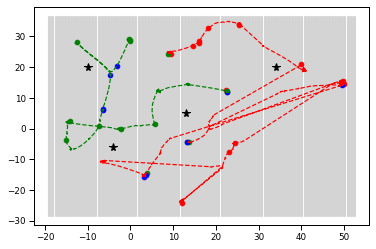

In [16]:
vertices = xy_grid.reshape(resolution**2, 2)

plt.scatter(vertices[:, 0], vertices[:, 1], c='lightgrey', marker='.')
plt.plot(forces_emb[:, 0], forces_emb[:, 1], 'r--')
plt.plot(bos_emb[:, 0], bos_emb[:, 1], 'g--')
plt.scatter(questions_embs[:15, 0], questions_embs[:15, 1], c='r', marker='o')
plt.scatter(questions_embs[15:30, 0], questions_embs[15:30, 1], c='g', marker='o')
plt.scatter(questions_embs[30:, 0], questions_embs[30:, 1], c='b', marker='o')
plt.plot(wordle_coords[:, 0], wordle_coords[:, 1], 'k*', markersize=8)
plt.show()

## Construct knowledge maps from memory traces for embedded lectures

In [17]:
lecture_embs = np.vstack((forces_emb, bos_emb))
maps_arr = np.empty((3, exp.n_participants, resolution, resolution), dtype=np.float64)

for qset in range(3):
    store_key = f'kmap_qset{qset}'
    for i, p in enumerate(tqdm(participants, desc=f'{qset+1}/3', leave=False)):
        # known values are knowledge traces for both lectures
        forces_trace = p.get_trace(f'forces_qset{qset}')
        bos_trace = p.get_trace(f'bos_qset{qset}')
        traces = np.hstack((forces_trace, bos_trace))
        # interpolate knowledge to regular grid using radial basis function
        knowledge_map = RBF_interp(lecture_embs, traces, vertices).reshape(resolution, resolution)
        # store in corresponding Participant instance
        p.store_trace(knowledge_map, store_key)
        maps_arr[qset, i] = knowledge_map
        
    # store average in avg participant
    avg_participant.store_trace(maps_arr[qset].mean(axis=0), store_key)

In [18]:
# save updated participant objects
exp.save_participants(allow_overwrite=True)

In [19]:
# uniformly shift coordinates to line up with heatmap bounds for plotting
shifted_inds = np.append(split_inds, [1137, 1141])
coords = np.vstack((embeddings, wordle_coords, vertices))
coords_shifted = coords - coords.min(axis=0)
coords_shifted /= (coords_shifted.max(axis=0) / resolution)
(
    forces_shifted, 
    bos_shifted, 
    questions_shifted, 
    wordle_coords_shifted, 
    _
) = np.vsplit(coords_shifted, shifted_inds)
ff_qs_shifted = questions_shifted[:15]
bos_qs_shifted = questions_shifted[15:30]
gen_qs_shifted = questions_shifted[30:]
# make sure split happened at correct indices
assert len(questions_shifted) == len(questions_embs)
assert len(wordle_coords_shifted) == len(wordle_coords)

## Plot knowledge and learning maps

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


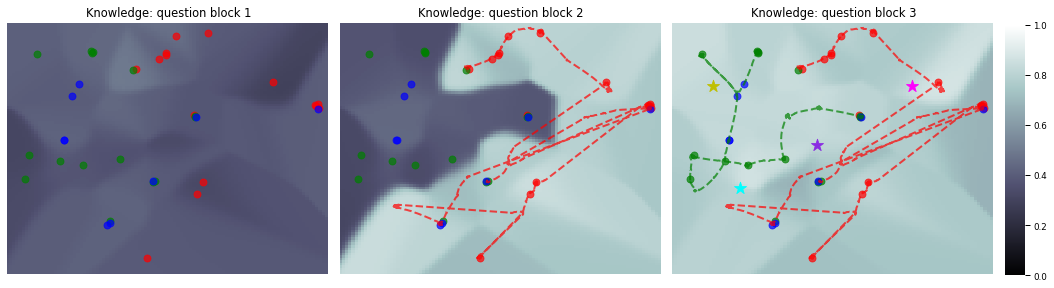

In [20]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(14, 4)
cbar_ax = fig.add_axes([1, 0.03, .02, .87])

for i in range(3):
    kmap = avg_participant.traces[f'kmap_qset{i}']
#     low, high = kmap.min().round(1), kmap.max().round(1)
#     print(low, high)
    cbar = True if i == 2 else False
    cax = cbar_ax if i == 2 else None
    sns.heatmap(kmap, vmin=0, vmax=1, cmap=cmap, xticklabels=[], yticklabels=[], 
                cbar=cbar, ax=axes[i], cbar_ax=cax)
    axes[i].collections[0].remove()
    axes[i].imshow(kmap, vmin=0, vmax=1, aspect='auto', cmap=cmap)
    axes[i].scatter(ff_qs_shifted[:, 0], ff_qs_shifted[:, 1], c='r', marker='o', s=50, alpha=.7)
    axes[i].scatter(bos_qs_shifted[:, 0], bos_qs_shifted[:, 1], c='g', marker='o', s=50, alpha=.7)
    axes[i].scatter(gen_qs_shifted[:, 0], gen_qs_shifted[:, 1], c='b', marker='o', s=50, alpha=.7)
    if i > 0:
        axes[i].plot(forces_shifted[:, 0], forces_shifted[:, 1], 'r--', alpha=.7, linewidth=2)
    if i > 1:
        axes[i].plot(bos_shifted[:, 0], bos_shifted[:, 1],'g--', alpha=.7, linewidth=2)
        for coord, color in zip(wordle_coords_shifted, ['y', 'cyan', 'blueviolet', 'fuchsia']):
            axes[i].scatter(coord[0], coord[1], c=color, marker='*', s=160)
        
    axes[i].set_title(f'Knowledge: question block {i + 1}', fontsize='large')
    # undo automatic y-axis inversion from sns.heatmap
    axes[i].invert_yaxis()
plt.tight_layout()
# plt.savefig(opj(fig_dir, 'knowledge_maps.pdf'), bbox_inches='tight', dpi=1000)
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


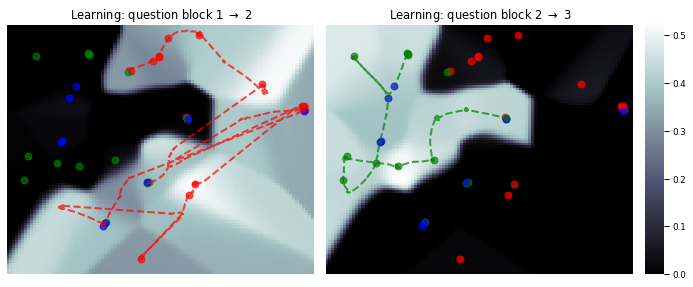

In [21]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(9, 4)
cbar_ax = fig.add_axes([1, 0.035, .03, .88])
for i in range(2):
    before = avg_participant.get_trace(f'kmap_qset{i}')
    after = avg_participant.get_trace(f'kmap_qset{i + 1}')
    learning_map = after - before
#     print(learning_map.min(), learning_map.max())
    cbar = True if i == 1 else False
    cax = cbar_ax if i == 1 else None
    sns.heatmap(learning_map, vmin=0, vmax=.53, cmap=cmap, xticklabels=[], 
                yticklabels=[], cbar=cbar, ax=axes[i], cbar_ax=cbar_ax)
    axes[i].collections[0].remove()
    axes[i].imshow(learning_map, vmin=0, vmax=.53, aspect='auto', cmap=cmap)
    axes[i].scatter(ff_qs_shifted[:, 0], ff_qs_shifted[:, 1], c='r', marker='o', s=50, alpha=.7)
    axes[i].scatter(bos_qs_shifted[:, 0], bos_qs_shifted[:, 1], c='g', marker='o', s=50, alpha=.7)
    axes[i].scatter(gen_qs_shifted[:, 0], gen_qs_shifted[:, 1], c='b', marker='o', s=50, alpha=.7)
    if i == 0:
        axes[i].plot(forces_shifted[:, 0], forces_shifted[:, 1], 'r--', alpha=.7, linewidth=2)
    else:
        axes[i].plot(bos_shifted[:, 0], bos_shifted[:, 1], 'g--', alpha=.7, linewidth=2)
    axes[i].set_title(fr'Learning: question block {i + 1} $\rightarrow$ {i + 2}', fontsize='large')
    # undo automatic y-axis inversion from sns.heatmap
    axes[i].invert_yaxis()
plt.tight_layout()
# plt.savefig(opj(fig_dir, 'learning_maps.pdf'), bbox_inches='tight', dpi=1000)
plt.show()

#### Figure legend

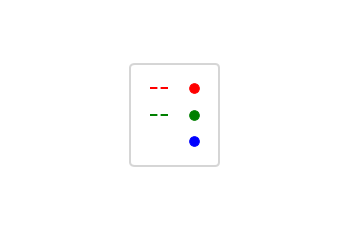

In [22]:
ft_hand = Line2D([], [], color='r', linestyle='--', linewidth=2)
bt_hand = Line2D([], [], color='g', linestyle='--', linewidth=2)
fq_hand = Line2D([], [], color='r', marker='o', linestyle='')
bq_hand = Line2D([], [], color='g', marker='o', linestyle='')
gq_hand = Line2D([], [], color='b', marker='o', linestyle='')
empty_hand = Line2D([], [], color=None, linestyle='')

handles = [ft_hand, bt_hand, empty_hand, fq_hand, bq_hand, gq_hand]
labels = [None] * 6
fig, ax = plt.subplots()
leg = fig.legend(
    handles, 
    labels, 
    loc='center', 
    ncol=2, 
    markerscale=2, 
    columnspacing=2.5, 
    labelspacing=2, 
    borderpad=2, 
    handletextpad=-.5
)
frame = leg.get_frame()
frame.set_linewidth(2)
frame.set_boxstyle('round', rounding_size=.5)
ax.axis('off')
# plt.savefig(opj(fig_dir, 'knowledge_maps_legend.pdf'), bbox_inches='tight')
plt.show()

## Create wordles for sample points

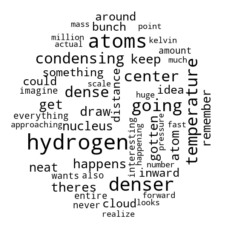

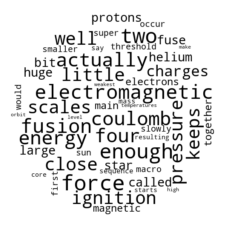

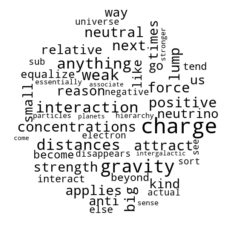

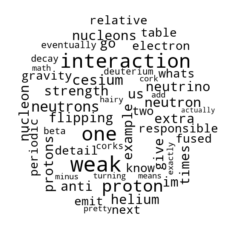

In [23]:
n_wordle_words = 50
vocabulary = CV.get_feature_names()
# get weights over corpus words for each topic vector
coords_wordweights = get_word_weights(wordle_vectors, LDA)

for i, coords in enumerate(coords_wordweights):
#     print(wordle_coords[i])
    weights_dict = topn(dict(zip(vocabulary, coords)), n_wordle_words)
    color_to_words = {'black': list(weights_dict)}
    color_func = SimpleGroupedColorFunc(color_to_words)
    fig, ax = plt.subplots(1)
    plot_wordle(ax, weights_dict, color_func, mask=wordle_mask)
    savepath = opj(fig_dir, f'wordle_{wordle_coords[i, 0]}_{wordle_coords[i, 1]}')
#     plt.savefig(savepath, dpi=500)
    plt.show()